# Sanafrekvenssien lasku korp-tiede tekstidatasetistä

Tässä notebookissa tehdään yleistason tekstidatan tarkastelua. Ensin lasketaan datasetin sanojen ja sanaparien (bigramien) frekvenssit ja lopuksi tarkastellaan sanojen kosini-samankaltaisuuksia toisiinsa T-SNE-kuvaajalla.<br>
Datasetti käsittelee Suomi24 foorumiviestejä, joissa on maininta sanasta "tiede". Datasetti haettiin <a href="https://korp.csc.fi/#?stats_reduce=word&cqp=%5B%5D&corpus=ftb3_europarl,ftb3_jrcacquis,ftb2,reittidemo">Kielipankin Korp-käyttöliittymällä</a>.

### Ladataan tarvittavat paketit

In [1]:
#from nltk.stem.snowball import SnowballStemmer # Paketti suomalaisten sanojen taivutusmuotojen poistamiseen, mutta datasetin termit ovat jo stemmattu
from IPython.core.display import display, HTML
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import pandas as pd
import itertools
#nltk.download('punkt')

#stemmer = SnowballStemmer("finnish")
display(HTML("<style>.container { width:100% !important; }</style>"))

### Ladataan ja tarkastellaan korp-datasettiä

In [2]:
testidata = pd.read_csv("korp_tiede.tsv", sep="\t", engine='python', encoding="latin-1")
testidata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
hit number       1000 non-null int64
corpus           1000 non-null object
tokens           1000 non-null object
lemmas           1000 non-null object
text_title       1000 non-null object
text_date        1000 non-null object
text_time        1000 non-null object
text_sect        1000 non-null object
text_sub         988 non-null object
text_user        889 non-null object
sentence_id      1000 non-null object
text_urlmsg      1000 non-null object
text_urlboard    1000 non-null object
licence          1000 non-null object
date             1000 non-null object
total hits       1000 non-null object
Korp URL         1000 non-null object
params           935 non-null object
dtypes: int64(1), object(17)
memory usage: 140.8+ KB


In [3]:
testidata.head()

,hit number,corpus,tokens,lemmas,text_title,text_date,text_time,text_sect,text_sub,text_user,sentence_id,text_urlmsg,text_urlboard,licence,date,total hits,Korp URL,params
0,0,S24,Jotkut ovat löytäneet hyviä juttukumppaneita e...,joku olla löytää hyvä juttukumppani esim Agric...,Yksin asuminen,16.12.2014,18:49,Terveys,Yksinäisyys,NaN,1815,http://keskustelu.suomi24.fi/t/13105899#commen...,http://keskustelu.suomi24.fi/t/13105899,CC BY-NC (CLARIN PUB),7.6.2020 18:44,1960,https://korp.csc.fi/#?corpus=s24&stats_reduce=...,"corpus=S24; cqp=[word = ""tiede""]; defaultconte..."
1,1,S24,"Yksilönä muutos voi mennä niin pitkälle , että...","yksilö muutos voida mennä niin pitkälle , että...",Lasten etu,17.12.2014,15:58,Suhteet,Avioero,fkjsdklfjklsdfj,4856,http://keskustelu.suomi24.fi/t/13116807#commen...,http://keskustelu.suomi24.fi/t/13116807,CC BY-NC (CLARIN PUB),7.6.2020 18:44,1960,https://korp.csc.fi/#?corpus=s24&stats_reduce=...,"corpus=S24; cqp=[word = ""tiede""]; defaultconte..."
2,2,S24,Vaikka tiede itse väittää olevansa melkeinpä a...,vaikka tiede itse väittää olla melkein ainu va...,Ikuinen ahdistus jo 20 vuotta,15.11.2014,16:24,Terveys,Ahdistus,Angus Beef Master,25606,http://keskustelu.suomi24.fi/t/12922821#commen...,http://keskustelu.suomi24.fi/t/12922821,CC BY-NC (CLARIN PUB),7.6.2020 18:44,1960,https://korp.csc.fi/#?corpus=s24&stats_reduce=...,"corpus=S24; cqp=[word = ""tiede""]; defaultconte..."
3,3,S24,"Fort pyrki ennen kaikkea osoittamaan sen , ett...","Fort pyrkiä ennen kaikki osoittaa se , että ti...",Ikuinen ahdistus jo 20 vuotta,15.11.2014,16:24,Terveys,Ahdistus,Angus Beef Master,25607,http://keskustelu.suomi24.fi/t/12922821#commen...,http://keskustelu.suomi24.fi/t/12922821,CC BY-NC (CLARIN PUB),7.6.2020 18:44,1960,https://korp.csc.fi/#?corpus=s24&stats_reduce=...,"corpus=S24; cqp=[word = ""tiede""]; defaultconte..."
4,4,S24,"Uskonnot kuluttavat resursseja , joita tiede t...","uskonto kuluttaa resurssi , joka tiede tuottaa .",Uskovaisuus näyttää vetävän,9.12.2014,22:23,Yhteiskunta,Yleistä politiikasta,Höpö-uskontoja,38368,http://keskustelu.suomi24.fi/t/12867435#commen...,http://keskustelu.suomi24.fi/t/12867435,CC BY-NC (CLARIN PUB),7.6.2020 18:44,1960,https://korp.csc.fi/#?corpus=s24&stats_reduce=...,"corpus=S24; cqp=[word = ""tiede""]; defaultconte..."


### Tekstidatan sanafrekvenssien lasku

In [4]:
from nltk.corpus import stopwords

stopWords = set(stopwords.words('finnish'))
specials = [",", ".", ">", "<", ";", ":", "!", "?", "[", "]", "{", "}", "(", ")", "/", "="]
wordsFiltered = []
stemmedWords = []
tokens = []

for teksti in testidata['lemmas']:
    tokens.append(word_tokenize(teksti))
    
tokens = list(itertools.chain.from_iterable(tokens)) # luikautetaan listat listassa yhdeksi listaksi
    
for token in tokens:
    if token not in stopWords and token not in specials:
        wordsFiltered.append(token)

"""
# Sanojen stemmaus: jos sanoja ei ole lemmatisoitu, niin tätä voi käyttää taivutusmuotojen poistamiseen

for word in wordsFiltered:
    stemmedWords.append(stemmer.stem(word))

for word in stemmedWords:
    try:
        if isinstance(int(word), int):
            stemmedWords.remove(word)
    except:
        pass

"""

wordfreq = {}

for word in wordsFiltered: # jos käytetään stemmausta -> stemmedWords:
        if word not in wordfreq.keys():
            wordfreq[word] = 1
        else:
            wordfreq[word] += 1

### Tulosten tarkastelu

In [5]:
df = pd.DataFrame.from_dict(wordfreq, orient='index', columns=['frekvenssi'])
df = df.reset_index()

df2 = df[df['index'].map(len) > 3]

df2.sort_values(by='frekvenssi', ascending=False).head(20)

,index,frekvenssi
10,tiede,1112
19,voida,170
106,ihminen,100
218,asia,98
303,mikään,86
44,kaikki,85
101,jokin,78
614,tuntea,72
139,sanoa,71
299,tutkia,68


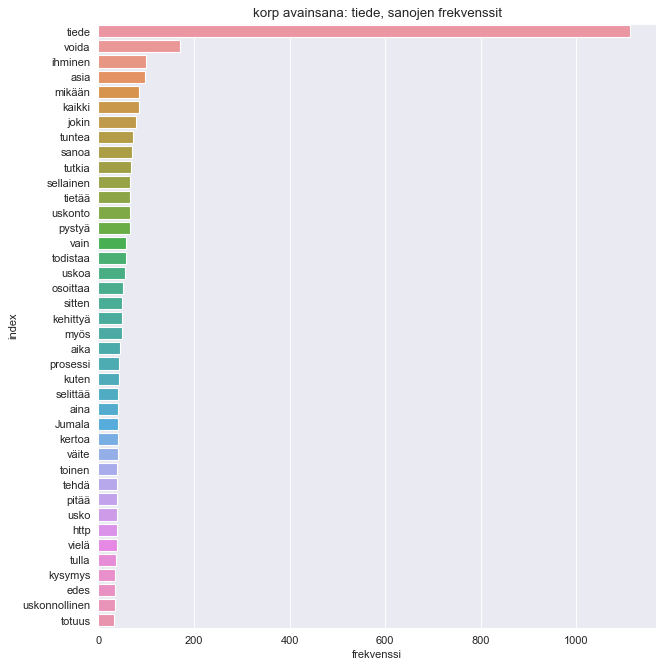

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[9,10], dpi=80)
sns.set_style("darkgrid")
plt.title("korp avainsana: tiede, sanojen frekvenssit")
sns.barplot(x="frekvenssi", y="index", data=df2.sort_values(by='frekvenssi', ascending=False).head(40))

Datasetissä ilmenee selkeästi eniten sana "tiede", mikä ei ole yllättävää, sillä datasetti haettiin Korp-käyttöliittymästä avainsanalla "tiede". Datasetissä kuitenkin ilmenee muita kiinnostavia sanoja, kuten "voida", mikä saattaa viitata, mitä tieteellä "voidaan" tehdä, taikka tietää. Lisäksi, datasetissä ilmenee uskontoon viittaavia termejä, mikä voi viitata tieteen ja uskonnon väliseen vertailuun foorumikeskusteluissa.

In [7]:
wordsFiltered2 = []
for word in wordsFiltered:
    if len(word) > 2: # haetaan vain 3 merkkiä pitkät sanat
        wordsFiltered2.append(word)
    else:
        pass
    
bigrams = (list(nltk.bigrams(wordsFiltered2))) # luodaan merkkijonoista bigramit

wordfreq2 = {}

# lasketaan bigramien frekvenssit
for bigram in bigrams:
        if bigram not in wordfreq2.keys():
            wordfreq2[bigram] = 1
        else:
            wordfreq2[bigram] += 1

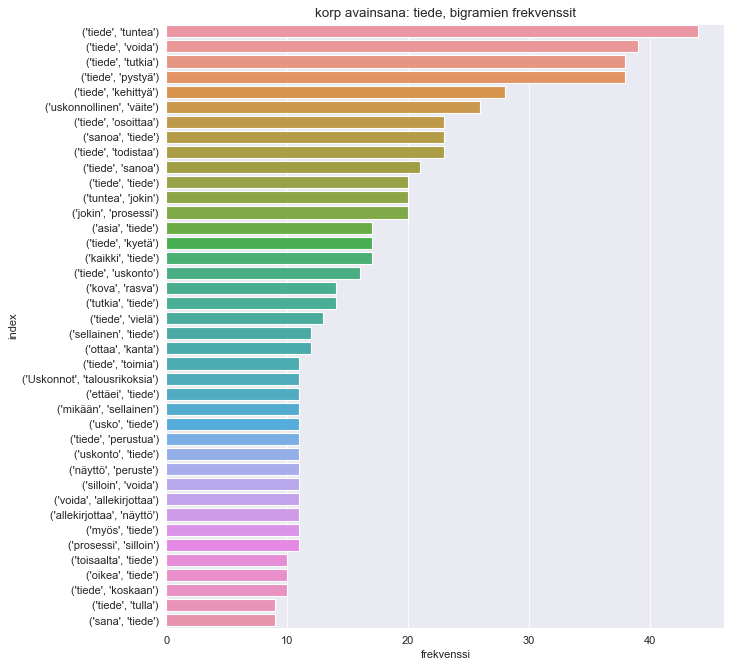

In [8]:
dfbg = pd.DataFrame.from_dict(wordfreq2, orient='index', columns=['frekvenssi'])
dfbg = dfbg.reset_index()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[9,10], dpi=80)
sns.set_style("darkgrid")
plt.title("korp avainsana: tiede, bigramien frekvenssit")
sns.barplot(x="frekvenssi", y="index", data=dfbg.sort_values(by='frekvenssi', ascending=False).head(40))

Datasetin bigramien frekvenssit vahvistavat aikaisempia havaintoja, mutta antavat hieman enemmän kontekstia. Bigramit osoittavat että foorumikeskusteluissa käsitellään etenkin mitä tiede tekee, kykenee, taikka väittää. Lisäksi, kuvaaja viittaa kuinka foorumikeskusteluissa vastakkainasetetaan tiedettä ja uskontoa.

## Datasetin sanojen kosini-samankaltaisuuden visualisointi T-SNE-kuvaajalla

### tSNE-kuvaaja

<a href="https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding">"T-distributed Stochastic Neighbor Embedding"</a> (tSNE) on visualisointiin sovellettu koneoppimisalgoritmi, joka epälineaarisella ulottuvuudenpelkistyksellä muuttaa moniulotteisen tiedon kaksiulotteiseksi pistekaavioksi.

tSNE-kuvaajan luomiseksi ensin tehdään <a href="https://arxiv.org/abs/1301.3781">Word2vec</a> embedding sanastolle (muutetaan tekstidata numeraaliseksi matriisiksi), joka määrittää sanojen <a href="https://en.wikipedia.org/wiki/Cosine_similarity">kosini samankaltaisuuden</a>. Tällä voidaan määrittää sanojen väliset suhteet. Word2vec mallista voidaan sitten kehittää tSNE-kuvaaja.

Tämän harjoittelun pohjana käytin Susan Lin artikkelia <i><a href="https://towardsdatascience.com/understanding-word2vec-embedding-in-practice-3e9b8985953">Understanding Word2vec Embedding in Practice</a></i>.

<a href="https://towardsdatascience.com/word2vec-made-easy-139a31a4b8ae"><img src="https://miro.medium.com/max/1720/1*3Eh6afALesGJ_1fkmBxxnQ.png" alt="Word2vec.png" width="700" align="center"></a>

<a href="https://towardsdatascience.com/word2vec-made-easy-139a31a4b8ae"><img src="https://www.machinelearningplus.com/wp-content/uploads/2018/10/3d_projection-961x1024.png" alt="cosine_similarity.png" width="400" align="center"></a>


### Tekstin esikäsittely Word2veciä varten

In [9]:
def review_to_words(raw_review):
    import re
    #
    # 1. Poistetaan merkit, jotka eivät ole kirjaimia.        
    #
    letters_only = re.sub("[^a-öA-Ö]", " ", raw_review) 
    #
    # 2. Poistetaan isot kirjaimet ja pilkotaan lauseet yksittäisiksi sanoiksi.
    words = letters_only.lower().split()
    #
    # 3. Poistetaan stoppisanat
    # 
    stopWords = set(stopwords.words('finnish'))
    meaningful_words = [w for w in words if not w in stopWords and not len(w) < 2]  #returns a list 
    #
    # 4. poistetaan liian lyhyet sanat
    #
    meaningful_words = [word for word in meaningful_words if len(word) > 3] 
    #
    # 5. Yhdistetään sanat takaisin yhtenäisiksi lauseiksi.
    #
    return( " ".join( meaningful_words ))

processed_wmn = [ review_to_words(text) for text in testidata["lemmas"]]

### Sanafrekvenssien määritys tSNE-kuvaajaa varten

In [10]:
def wordfreqs(processed_wmn):

    wordfreq = {}
    tokens=[]
    
    for text in processed_wmn:
        tokens.append(word_tokenize(text))
        
    tokens = list(itertools.chain.from_iterable(tokens))
    
    # summataan sanojen frekvenssit dictiin
    for token in tokens:
            if token not in wordfreq.keys():
                wordfreq[token] = 1
            else:
                wordfreq[token] += 1
    
    # muutetaan sanafrekvenssien dict dataframeksi
    df = pd.DataFrame.from_dict(wordfreq, orient='index', columns=['frekvenssi'])
    df = df.reset_index()
    
    return df

wordfreq = wordfreqs(processed_wmn)

### Luodaan corpus Word2veciä varten

In [11]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)    
           
    return corpus

corpus = build_corpus(processed_wmn)

### Luodaan Word2vec-malli

In [12]:
# load the word2vec algorithm from the gensim library
from gensim.models import word2vec
# run the model
model = word2vec.Word2Vec(corpus, size=100, window=6, min_count=10, workers=6, seed=1) # min_count=10 vastaa sanafrekvenssin minimimäärää

### Luodaan tSNE-kuvaaja

C:\Users\T450\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



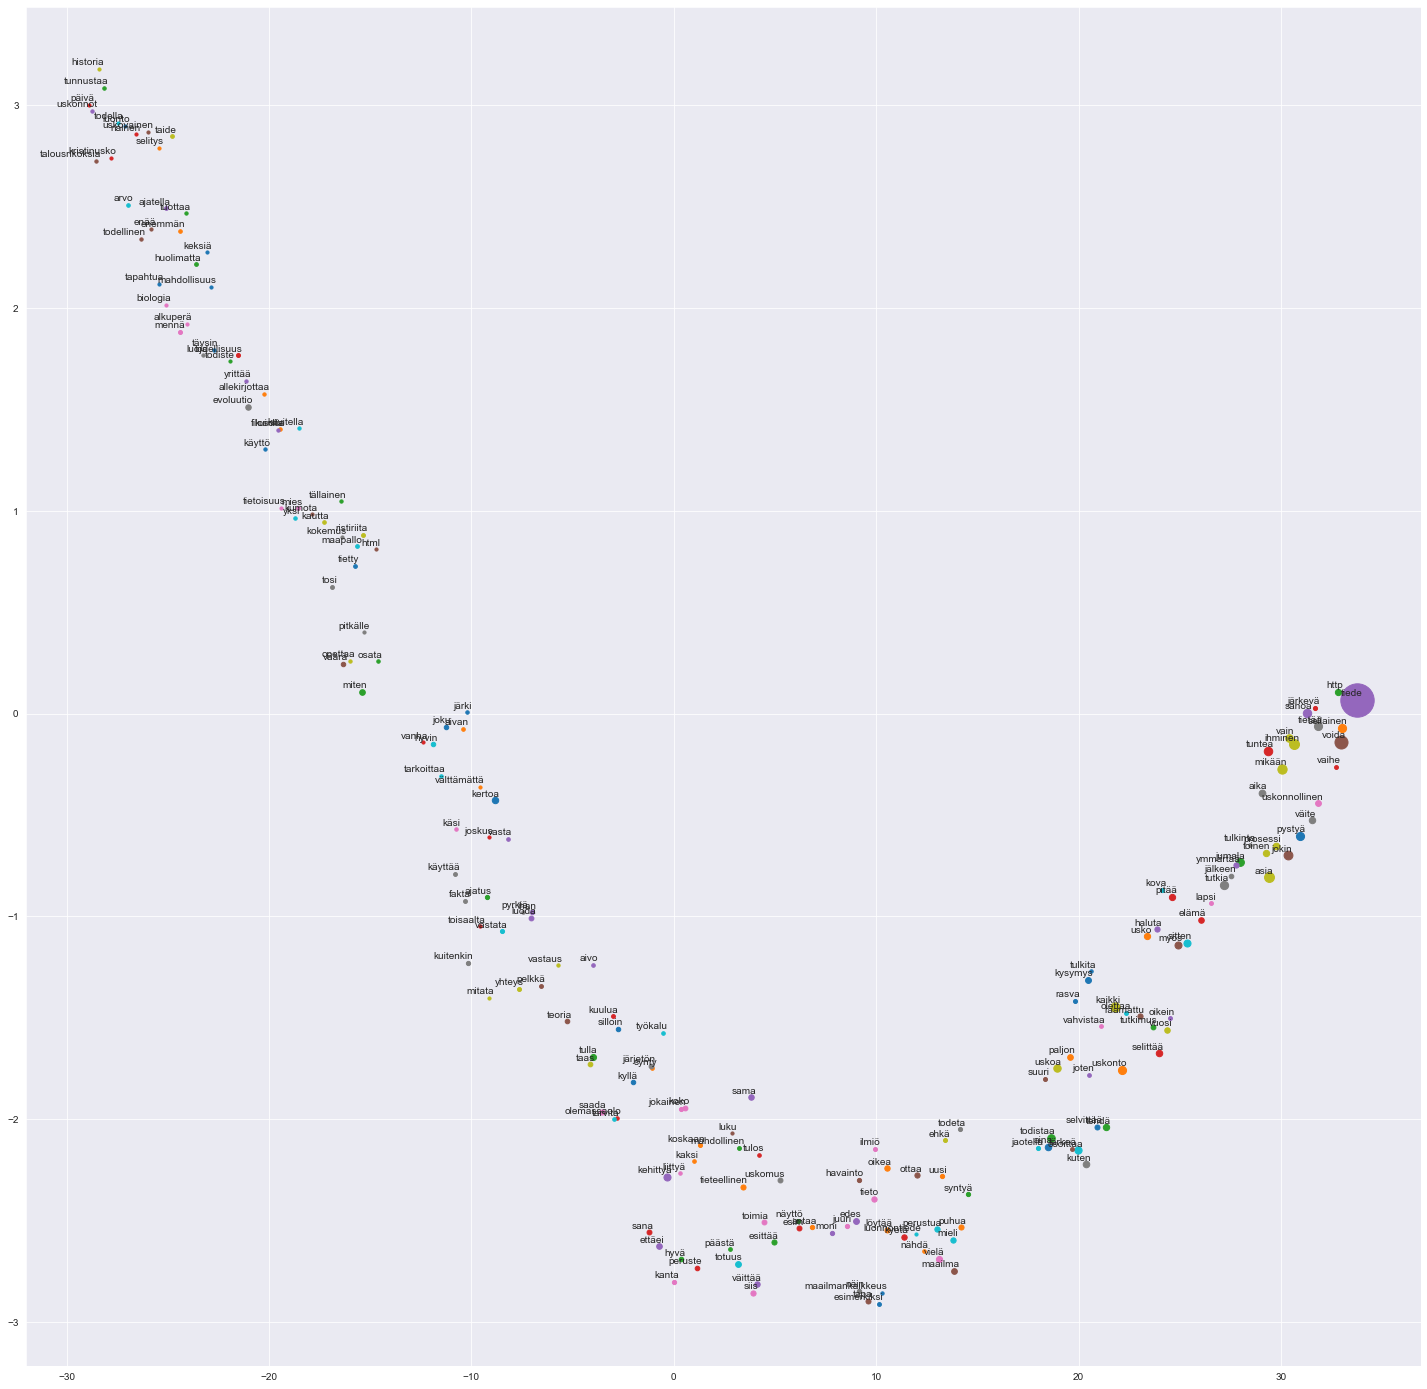

In [16]:
# import the t-SNE library and matplotlib for plotting
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import normalize

# define the function to compute the dimensionality reduction
# and then produce the biplot
def tsne_plot(model, df):
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []
    wordfreqs = []
    for word, frequence in zip(list(df["index"]), list(df["frekvenssi"])):
        for word2 in model.wv.vocab:
            if word == word2:
                wordfreqs.append(frequence)
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2500)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    plt.figure(figsize=(25, 25)) 
    
    fig = go.Figure()
    
    for i in range(len(x)):
        plt.scatter(x[i],y[i], s=wordfreqs[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    # Add traces
    fig.add_trace(go.Scatter(x=x, y=y,
                        marker=dict(size= [x/10 for x in wordfreqs]),
                        mode='markers',
                        text=labels))

    plt.show()
    fig.show()
    fig.write_html("T-SNE_sanaplot")

# call the function on our dataset
tsne_plot(model, wordfreq)

T-SNE-kuvaajan kehittymisessä on aina satunnaisuuden elementti, joten joka kerta kuvaaja tulee olemaan hieman erilainen. Siksi sanamerkityksien tulkinnassa se kelpaa vain erittäin pintapuoliseen arviointiin.

### Klusterien tarkastelu aikaisemmasta suorituskerrasta

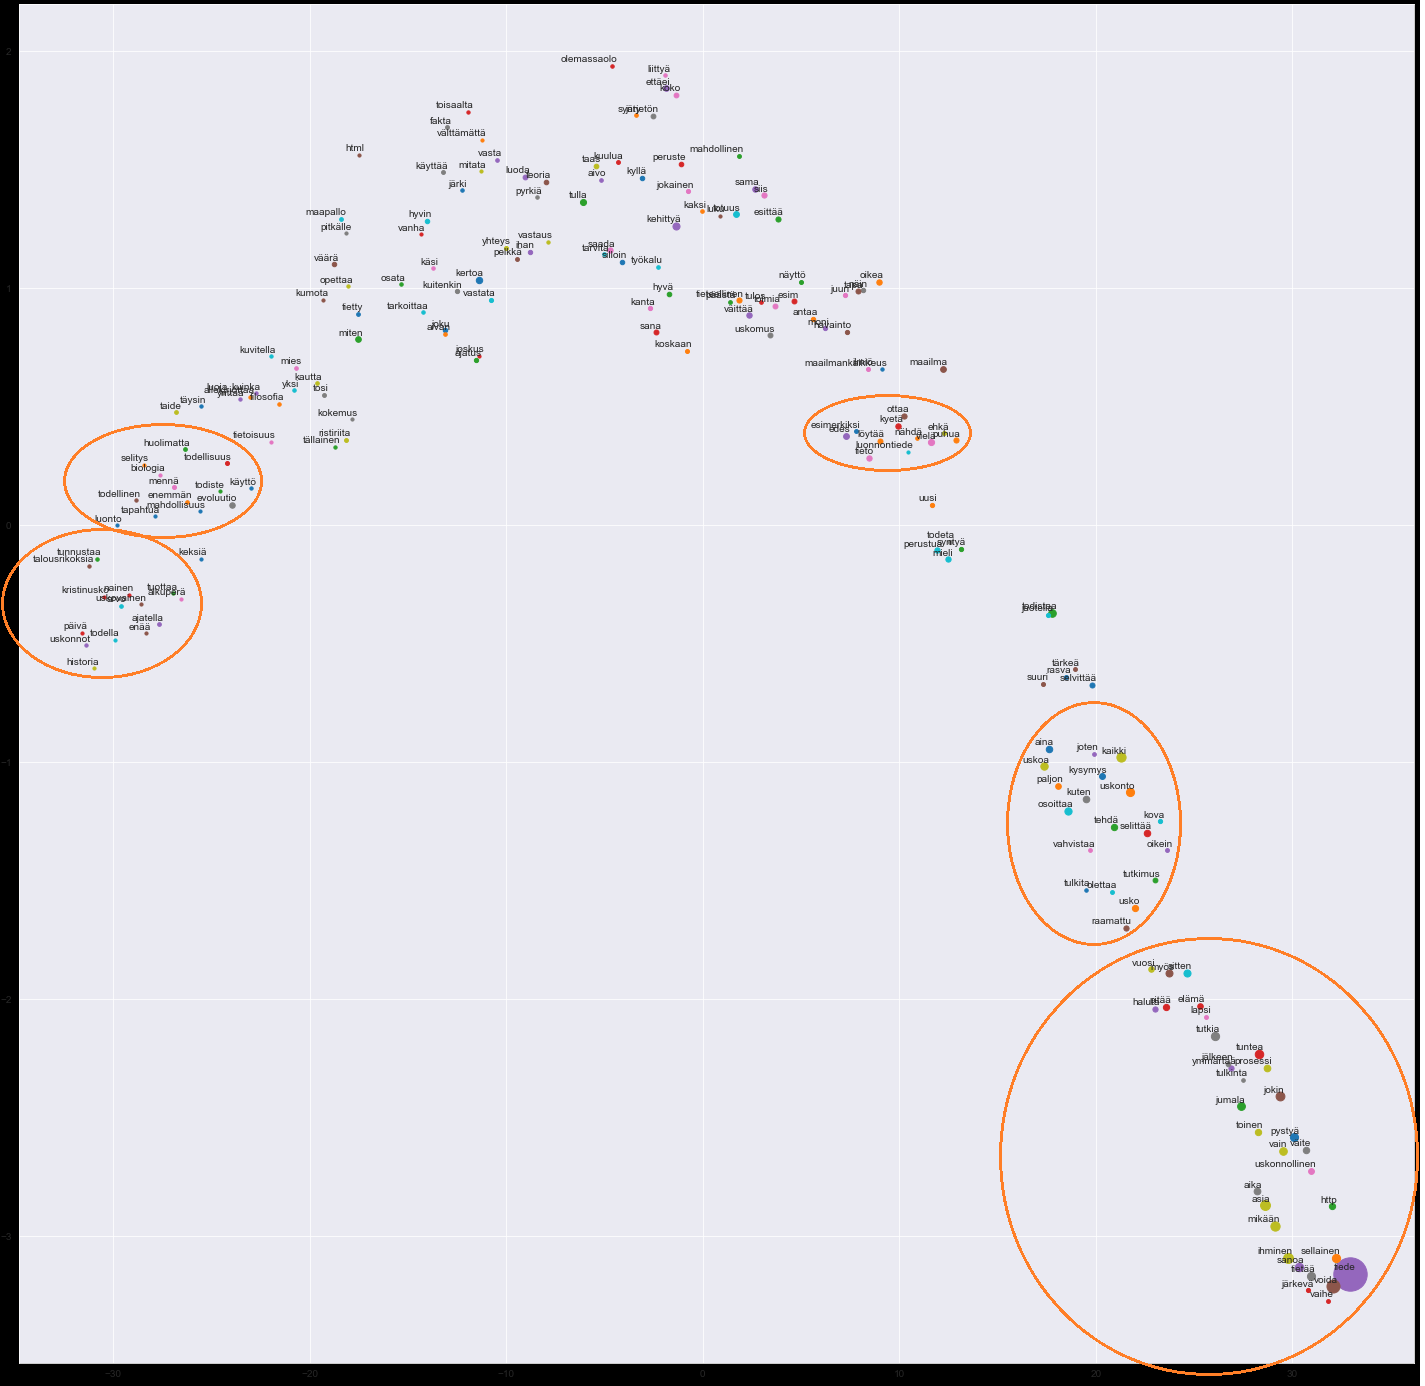

Sanaklusterien analyysi aikaisemmasta suorituskerrasta. .T-SNE kuvaajassa voidaan havaita selkeä hevosenkengän muoto. Kuvaajan vasemmassa laidassa ilmenee korkeamman tason termejä, mahdollisesti viitaten, että kyseisiä termejä on käytetty enemmän abstrakteja aiheita käsittelevissä keskusteluissa. Oikeassa laidassa ilmenee enemmän toimintaan viittaavia termejä, mikä voi viitata siihen, että kyseisiä termejä on käytetty enemmän konkreettisia aiheita käsittelevissä keskusteluissa.